***Importing Libraries***

In [1]:
import gym
import numpy as np
from collections import deque
import random
import tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
seed=0
np.random.seed(seed)
tensorflow.set_random_seed(seed)

C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

In [2]:
Sequential=tensorflow.keras.models.Sequential
Dense=tensorflow.keras.layers.Dense 
Adam=tensorflow.keras.optimizers.Adam

***Initialization of Environment***

In [3]:
env_to_use='MountainCar-v0'
class MountainCar():
    
    def __init__(self):
        self.env = gym.make(env_to_use) 
        self.env.seed(seed)
        self.action_shape = (self.env.action_space.n,)
        self.state_shape = self.env.observation_space.shape
        #print("Env Space : ", self.state_shape)
        #print("Action Space : ", self.action_shape)
        self.test_mode = False
    
    def reset(self):
        return self.env.reset()
    
    def sample(self):
        return self.env.action_space.sample()
    
    def step(self, action):
        state, reward, terminal, _ = self.env.step(int(action))
        #reward = 0
        
        #if terminal:
            #if state[0] > 0.5:
                #reward = 1
            #else:
                #reward = state[0] + 0.5
         
        return state, reward, terminal
    
    
                
MC = MountainCar()
st_shape=MC.state_shape[0]
act_shape=MC.action_shape[0]




In [4]:
action_list = [0,1,2]
gamma =0.45
lr =0.001
num_episodes = 1000#1000
epsilon =1
epsilon_decay =0.995
memory_size =1000
batch_size=100
show=False


In [5]:
factor=[1,100]

In [6]:
memory=deque(maxlen=memory_size)
s=MC.reset()
s = s.reshape((1,-1))
s = s*factor
for _ in range(memory_size):
    a = np.random.randint(0,act_shape)
    new_s,r,d =MC.step(a)
    new_s = new_s.reshape((1,-1))
    new_s = new_s*factor
    if show:
        MC.render()
    if d:
        r=-100
        experience =(s,r,a,new_s,d)
        s=MC.reset()
        s = s.reshape((1,-1))
    else:    
        experience =(s,r,a,new_s,d)
    memory.append(experience)
    s = new_s
  

***Model Definition***

Here , I have defined the model as a simple MLP neural network with 2 hidden layers of 100 nodes with ```relu``` activation function

In [7]:
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(st_shape,)))
model.add(Dense(100,activation='relu'))
#model.add(Dense(act_shape,activation='softmax'))
model.add(Dense(act_shape,activation='linear'))
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr),)
model.compile(loss='mse',optimizer=Adam(lr=lr),)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 10,703
Trainable params: 10,703
Non-trainable params: 0
_________________________________________________________________


In [8]:
ep_list =[]
reward_list =[] 
index=0 
oh = OneHotEncoder(categories=[range(3)])
for ep in range(num_episodes):
    s= MC.reset()
    s=s.reshape((1,-1))
    s = s*factor
    total_rewards =0
    d = False
    j = 0
    for j in range(200):
        if np.random.random()< epsilon:
            a = np.random.randint(0,len(action_list))
        else:
            Q = model.predict(s.reshape(1,-1))
            a =np.argmax(Q)
        new_s,r,d = MC.step(a)
        new_s = new_s.reshape((1,-1))
        new_s = new_s*factor
        total_rewards=total_rewards+r
        if show:
            MC.render()
        if d:
            if total_rewards<-199:
                r =-100
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Failed! Reward %d"%(ep,total_rewards))
            elif total_rewards<-110 and total_rewards>-199:
                r=10
                d=True
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Better! Reward %d"%(ep,total_rewards))
            elif total_rewards>=-110:
                r=100
                experience = (s,r,a,new_s,d)
                memory.append(experience)

                print("Episode %d, Passed! Reward %d"%(ep,total_rewards))
            ep_list.append(ep)
            reward_list.append(total_rewards)
            break
        
        experience = (s,r,a,new_s,d)
        memory.append(experience)
        if j==199:
            print("Reward %d after full episode"%(total_rewards))
            
        s = new_s
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches],ndmin=3).reshape(len(batches),-1)
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    actions=oh.fit_transform(actions.reshape(-1,1)).toarray()
    actions = actions.reshape(-1,act_shape)
    new_states= np.array([batch[3] for batch in batches],ndmin=3).reshape(len(batches),-1)
    dones= np.array([batch[4] for batch in batches])
    Qs =model.predict(states)
    new_Qs = model.predict(new_states)
    target_Qs=rewards+gamma*(np.max(new_Qs,axis=1)*(~dones))
    Qs[actions==1]=target_Qs#.reshape(-1,)
    model.fit(states,Qs,verbose=0 )
    epsilon=epsilon*epsilon_decay


Episode 0, Failed! Reward -200
Episode 1, Failed! Reward -200
Episode 2, Failed! Reward -200
Episode 3, Failed! Reward -200
Episode 4, Failed! Reward -200
Episode 5, Failed! Reward -200
Episode 6, Failed! Reward -200
Episode 7, Failed! Reward -200
Episode 8, Failed! Reward -200
Episode 9, Failed! Reward -200
Episode 10, Failed! Reward -200
Episode 11, Failed! Reward -200
Episode 12, Failed! Reward -200
Episode 13, Failed! Reward -200
Episode 14, Failed! Reward -200
Episode 15, Failed! Reward -200
Episode 16, Failed! Reward -200
Episode 17, Failed! Reward -200
Episode 18, Failed! Reward -200
Episode 19, Failed! Reward -200
Episode 20, Failed! Reward -200
Episode 21, Failed! Reward -200
Episode 22, Failed! Reward -200
Episode 23, Failed! Reward -200
Episode 24, Failed! Reward -200
Episode 25, Failed! Reward -200
Episode 26, Failed! Reward -200
Episode 27, Failed! Reward -200
Episode 28, Failed! Reward -200
Episode 29, Failed! Reward -200
Episode 30, Failed! Reward -200
Episode 31, Failed

Episode 253, Failed! Reward -200
Episode 254, Failed! Reward -200
Episode 255, Failed! Reward -200
Episode 256, Failed! Reward -200
Episode 257, Failed! Reward -200
Episode 258, Failed! Reward -200
Episode 259, Failed! Reward -200
Episode 260, Failed! Reward -200
Episode 261, Failed! Reward -200
Episode 262, Failed! Reward -200
Episode 263, Failed! Reward -200
Episode 264, Failed! Reward -200
Episode 265, Failed! Reward -200
Episode 266, Failed! Reward -200
Episode 267, Failed! Reward -200
Episode 268, Failed! Reward -200
Episode 269, Failed! Reward -200
Episode 270, Failed! Reward -200
Episode 271, Failed! Reward -200
Episode 272, Failed! Reward -200
Episode 273, Failed! Reward -200
Episode 274, Failed! Reward -200
Episode 275, Failed! Reward -200
Episode 276, Failed! Reward -200
Episode 277, Failed! Reward -200
Episode 278, Failed! Reward -200
Episode 279, Failed! Reward -200
Episode 280, Failed! Reward -200
Episode 281, Failed! Reward -200
Episode 282, Failed! Reward -200
Episode 28

Episode 503, Failed! Reward -200
Episode 504, Failed! Reward -200
Episode 505, Failed! Reward -200
Episode 506, Failed! Reward -200
Episode 507, Failed! Reward -200
Episode 508, Failed! Reward -200
Episode 509, Failed! Reward -200
Episode 510, Failed! Reward -200
Episode 511, Failed! Reward -200
Episode 512, Failed! Reward -200
Episode 513, Failed! Reward -200
Episode 514, Failed! Reward -200
Episode 515, Failed! Reward -200
Episode 516, Failed! Reward -200
Episode 517, Failed! Reward -200
Episode 518, Failed! Reward -200
Episode 519, Failed! Reward -200
Episode 520, Failed! Reward -200
Episode 521, Failed! Reward -200
Episode 522, Failed! Reward -200
Episode 523, Failed! Reward -200
Episode 524, Better! Reward -122
Episode 525, Better! Reward -126
Episode 526, Failed! Reward -200
Episode 527, Better! Reward -121
Episode 528, Better! Reward -124
Episode 529, Better! Reward -122
Episode 530, Better! Reward -135
Episode 531, Failed! Reward -200
Episode 532, Failed! Reward -200
Episode 53

Episode 752, Passed! Reward -87
Episode 753, Passed! Reward -88
Episode 754, Better! Reward -113
Episode 755, Better! Reward -114
Episode 756, Passed! Reward -87
Episode 757, Better! Reward -116
Episode 758, Better! Reward -113
Episode 759, Passed! Reward -87
Episode 760, Better! Reward -117
Episode 761, Passed! Reward -97
Episode 762, Better! Reward -119
Episode 763, Better! Reward -121
Episode 764, Better! Reward -117
Episode 765, Better! Reward -122
Episode 766, Better! Reward -124
Episode 767, Better! Reward -120
Episode 768, Better! Reward -120
Episode 769, Better! Reward -121
Episode 770, Better! Reward -124
Episode 771, Better! Reward -123
Episode 772, Better! Reward -120
Episode 773, Better! Reward -120
Episode 774, Passed! Reward -89
Episode 775, Better! Reward -121
Episode 776, Better! Reward -124
Episode 777, Better! Reward -114
Episode 778, Better! Reward -121
Episode 779, Better! Reward -116
Episode 780, Better! Reward -114
Episode 781, Better! Reward -113
Episode 782, Bet

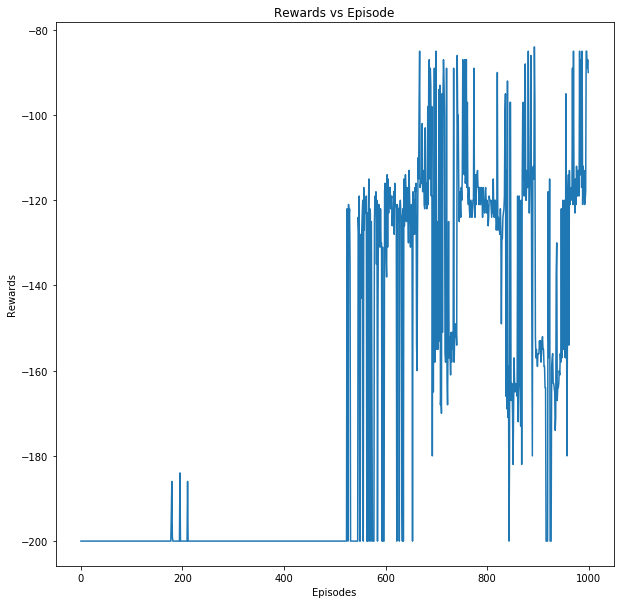

In [9]:
plt.figure(figsize=(10,10))
plt.plot(reward_list)
plt.title("Rewards vs Episode")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.savefig('DQN_MC.png')

In [12]:
np.argmax(reward_list)

922

In [17]:
import time
import cv2
env=gym.make(env_to_use)
env.seed(0)
obs=env.reset()

#os.mkdir(env_to_use+'Test')
#os.mkdir(env_to_use+'Test/img/')
print(obs.shape)
i=0
while(1):
    _action= model.predict(obs.reshape(1,-1)).reshape(-1)
    obs,rew,done,info=env.step(np.argmax(_action))
    img=env.render(mode='rgb_array')
    #time.sleep(0.1)
    cv2.imwrite(env_to_use+'Test/img/'+str(i)+'.jpg',img)
    i+=1
    if done==True:
        break
env.close()

(2,)


In [13]:
print('Maximum Reward',np.max(reward_list))

Maximum Reward -88.0


In [41]:
done,i

(True, 200)